# IBM AML 데이터 EDA

## 시각화: 전체 거래 vs 일반 거래 vs 사기거래 분포비교
- 시간대별 거래량 비교
- 날짜별 거래량 비교
- 평균거래량 비교
- 사기계좌에서 사기거래가 차지하는 비율(평균비율)
- 거래목적 비교
- 거래방법 비교
- 거래빈도의 차이

# 데이터 불러오기

In [9]:
# 라이브러리 불러오기
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import os
import warnings
warnings.filterwarnings("ignore")

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, roc_auc_score, roc_curve
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

from sklearn.metrics import classification_report, confusion_matrix

In [122]:
# hi_small 데이터 불러오기
base_dir = "C:\\Users\\Admin\\iCloudDrive\\archive"
file_name = "HI-Small_Trans.csv"
file_path = os.path.join(base_dir, file_name)
df = pd.read_csv(file_path)

In [123]:
# hi_small 데이터 확인
display(df.info())
display(df.head(2))
display(df.tail(2))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5078345 entries, 0 to 5078344
Data columns (total 11 columns):
 #   Column              Dtype  
---  ------              -----  
 0   Timestamp           object 
 1   From Bank           int64  
 2   Account             object 
 3   To Bank             int64  
 4   Account.1           object 
 5   Amount Received     float64
 6   Receiving Currency  object 
 7   Amount Paid         float64
 8   Payment Currency    object 
 9   Payment Format      object 
 10  Is Laundering       int64  
dtypes: float64(2), int64(3), object(6)
memory usage: 426.2+ MB


None

,Timestamp,From Bank,Account,To Bank,Account.1,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering
0,2022/09/01 00:20,10,8000EBD30,10,8000EBD30,3697.34,US Dollar,3697.34,US Dollar,Reinvestment,0
1,2022/09/01 00:20,3208,8000F4580,1,8000F5340,0.01,US Dollar,0.01,US Dollar,Cheque,0


,Timestamp,From Bank,Account,To Bank,Account.1,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering
5078343,2022/09/10 23:46,256398,8148A6311,256398,8148A8711,0.038417,Bitcoin,0.038417,Bitcoin,Bitcoin,0
5078344,2022/09/10 23:37,154518,8148A6091,256398,8148A8711,0.281983,Bitcoin,0.281983,Bitcoin,Bitcoin,0


# 데이터 전처리

## 컬럼명 변경
- 송금계좌: Account -> Sender Account
- 수취계좌: Account.1 -> Recipient Account

In [128]:
# 컬럼명 변경
df.rename(columns ={"Account":"Sender Account", "Account.1":"Recipient Account"}, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5078345 entries, 0 to 5078344
Data columns (total 11 columns):
 #   Column              Dtype  
---  ------              -----  
 0   Timestamp           object 
 1   From Bank           int64  
 2   Sender Account      object 
 3   To Bank             int64  
 4   Recipient Account   object 
 5   Amount Received     float64
 6   Receiving Currency  object 
 7   Amount Paid         float64
 8   Payment Currency    object 
 9   Payment Format      object 
 10  Is Laundering       int64  
dtypes: float64(2), int64(3), object(6)
memory usage: 426.2+ MB


## 데이터 타입 변경

In [131]:
# 데이터 타입변경
import pandas as pd
# Convert the Timestamp column to a datetime dtype
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Convert the From Bank column to a category dtype
df['From Bank'] = df['From Bank'].astype('category')

# Convert the Account column to a string dtype
df['Sender Account'] = df['Sender Account'].astype('string')

# Convert the To Bank column to a category dtype
df['To Bank'] = df['To Bank'].astype('category')

# Convert the Account_1 column to a string dtype
df['Recipient Account'] = df['Recipient Account'].astype('string')

# Convert the Amount Received column to a float dtype
df['Amount Received'] = df['Amount Received'].astype('float')

# Convert the Receiving Currency column to a category dtype
df['Receiving Currency'] = df['Receiving Currency'].astype('category')

# Convert the Amount Paid column to a float dtype
df['Amount Paid'] = df['Amount Paid'].astype('float')

# Convert the Payment Currency column to a category dtype
df['Payment Currency'] = df['Payment Currency'].astype('category')

# Convert the Payment Format column to a category dtype
df['Payment Format'] = df['Payment Format'].astype('category')

# Convert the Is Laundering column to a category dtype
df['Is Laundering'] = df['Is Laundering'].astype('category')

In [132]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5078345 entries, 0 to 5078344
Data columns (total 11 columns):
 #   Column              Dtype         
---  ------              -----         
 0   Timestamp           datetime64[ns]
 1   From Bank           category      
 2   Sender Account      string        
 3   To Bank             category      
 4   Recipient Account   string        
 5   Amount Received     float64       
 6   Receiving Currency  category      
 7   Amount Paid         float64       
 8   Payment Currency    category      
 9   Payment Format      category      
 10  Is Laundering       category      
dtypes: category(6), datetime64[ns](1), float64(2), string(2)
memory usage: 234.3 MB


## 새로운 컬럼 생성
- Timestamp의 원래 컬럼을 보존하고, 날짜만 분리한 Date 컬럼 생성하기
- 각각 요일, 시(hour)를 나타내는 Day of Week, Hour를 생성
  - 시간 데이터는 순환적 특성을 가지므로 사인, 코사인 변환(hour_sin, hour_cos)을 해주기
- 보낸 금액과 받은 금액의 차이를 나타내는 Charge컬럼 생성

In [147]:
# 새로운 컬럼 생성
df['Date'] = df['Timestamp'].dt.date     # Timestamp에서 날짜 데이터만 추출
df['Date'] = pd.to_datetime(df['Date'], format="%Y-%m-%d")  # object로 된 Date를 datetime으로 바꿔주기

df['Hour'] = df['Timestamp'].dt.hour
df['Day of Week'] = df['Timestamp'].dt.dayofweek.astype('category')  # 0(월) ~ 6(일)
df['Charge'] = df['Amount Paid'] - df['Amount Received']

# 시간 데이터를 sin, cos 변환 (순환 특성 반영)
df['hour_sin'] = np.sin(2 * np.pi * df['Hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['Hour'] / 24)

In [148]:
df.head(3)

,Timestamp,From Bank,Sender Account,To Bank,Recipient Account,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering,Date,Hour,Day of Week,Charge,hour_sin,hour_cos
0,2022-09-01 00:20:00,10,8000EBD30,10,8000EBD30,3697.34,US Dollar,3697.34,US Dollar,Reinvestment,0,2022-09-01,0,3,0.0,0.0,1.0
1,2022-09-01 00:20:00,3208,8000F4580,1,8000F5340,0.01,US Dollar,0.01,US Dollar,Cheque,0,2022-09-01,0,3,0.0,0.0,1.0
2,2022-09-01 00:00:00,3209,8000F4670,3209,8000F4670,14675.57,US Dollar,14675.57,US Dollar,Reinvestment,0,2022-09-01,0,3,0.0,0.0,1.0


In [151]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5078345 entries, 0 to 5078344
Data columns (total 17 columns):
 #   Column              Dtype         
---  ------              -----         
 0   Timestamp           datetime64[ns]
 1   From Bank           category      
 2   Sender Account      string        
 3   To Bank             category      
 4   Recipient Account   string        
 5   Amount Received     float64       
 6   Receiving Currency  category      
 7   Amount Paid         float64       
 8   Payment Currency    category      
 9   Payment Format      category      
 10  Is Laundering       category      
 11  Date                datetime64[ns]
 12  Hour                int32         
 13  Day of Week         category      
 14  Charge              float64       
 15  hour_sin            float64       
 16  hour_cos            float64       
dtypes: category(7), datetime64[ns](2), float64(5), int32(1), string(2)
memory usage: 413.5 MB


# 기술통계량 확인
- 날짜, 수치형: numeric, datetime
- 문자형: object, category

In [155]:
# numeric, datetime형태의 기술통계량
df.describe()

,Timestamp,Amount Received,Amount Paid,Date,Hour,Charge,hour_sin,hour_cos
count,5078345,5.078345e+06,5.078345e+06,5078345,5.078345e+06,5.078345e+06,5.078345e+06,5.078345e+06
mean,2022-09-05 07:16:08.194274816,5.988726e+06,4.509273e+06,2022-09-04 20:18:23.453348096,1.049247e+01,-1.479453e+06,5.623688e-04,8.665654e-02
min,2022-09-01 00:00:00,1.000000e-06,1.000000e-06,2022-09-01 00:00:00,0.000000e+00,-6.179892e+11,-1.000000e+00,-1.000000e+00
25%,2022-09-02 04:32:00,1.833700e+02,1.844800e+02,2022-09-02 00:00:00,4.000000e+00,0.000000e+00,-7.071068e-01,-7.071068e-01
50%,2022-09-05 12:16:00,1.411010e+03,1.414540e+03,2022-09-05 00:00:00,1.000000e+01,0.000000e+00,0.000000e+00,2.588190e-01
75%,2022-09-08 03:13:00,1.234627e+04,1.229784e+04,2022-09-08 00:00:00,1.700000e+01,0.000000e+00,7.071068e-01,8.660254e-01
max,2022-09-18 16:18:00,1.046302e+12,1.046302e+12,2022-09-18 00:00:00,2.300000e+01,5.181636e+09,1.000000e+00,1.000000e+00
std,NaN,1.037183e+09,8.697728e+08,NaN,7.362643e+00,5.576961e+08,6.758409e-01,7.319355e-01


In [96]:
# print("{:.5f}".format(0.000000e+00))

In [157]:
# string, category 기술통계량
df.describe(exclude=["int","float","datetime"])  

,From Bank,Sender Account,To Bank,Recipient Account,Receiving Currency,Payment Currency,Payment Format,Is Laundering,Day of Week
count,5078345,5078345,5078345,5078345,5078345,5078345,5078345,5078345,5078345
unique,30470,496995,15811,420636,15,15,7,2,7
top,70,100428660,10,100428660,US Dollar,US Dollar,Cheque,0,3
freq,449859,168672,42547,1084,1879341,1895172,1864331,5073168,1597740


## 사기여부에 따라 데이터를 나누기

In [105]:
df['Is Laundering'].value_counts()

Is Laundering
0    5073168
1       5177
Name: count, dtype: int64

In [107]:
# 사기여부에 따라 데이터를 나누기
df_0 = df[df['Is Laundering']==0]
df_1 = df[df['Is Laundering']==1]

In [115]:
display(df_0.head(2))
print(df_0.shape)
display(df_1.head(2))
print(df_1.shape)

,Timestamp,From Bank,Sender Account,To Bank,Recipient Account,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering,Date,Time,Hour,Day of Week,Charge
0,2022-09-01 00:20:00,10,8000EBD30,10,8000EBD30,3697.34,US Dollar,3697.34,US Dollar,Reinvestment,0,2022-09-01,00:20:00,0,3,0.0
1,2022-09-01 00:20:00,3208,8000F4580,1,8000F5340,0.01,US Dollar,0.01,US Dollar,Cheque,0,2022-09-01,00:20:00,0,3,0.0


(5073168, 16)


,Timestamp,From Bank,Sender Account,To Bank,Recipient Account,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering,Date,Time,Hour,Day of Week,Charge
4742,2022-09-01 00:21:00,70,100428660,1124,800825340,389769.39,US Dollar,389769.39,US Dollar,Cheque,1,2022-09-01,00:21:00,0,3,0.0
40621,2022-09-01 00:03:00,70,100428660,11474,805B716C0,29024.33,US Dollar,29024.33,US Dollar,Credit Card,1,2022-09-01,00:03:00,0,3,0.0


(5177, 16)


## 범주형 데이터 확인

### 통화(currency)종류 확인

In [165]:
df['Receiving Currency'].unique()

['US Dollar', 'Bitcoin', 'Euro', 'Australian Dollar', 'Yuan', ..., 'Canadian Dollar', 'Swiss Franc', 'Brazil Real', 'Saudi Riyal', 'Shekel']
Length: 15
Categories (15, object): ['Australian Dollar', 'Bitcoin', 'Brazil Real', 'Canadian Dollar', ..., 'UK Pound', 'US Dollar', 'Yen', 'Yuan']

In [167]:
df['Payment Currency'].unique()

['US Dollar', 'Bitcoin', 'Euro', 'Australian Dollar', 'Yuan', ..., 'Canadian Dollar', 'Swiss Franc', 'Brazil Real', 'Saudi Riyal', 'Shekel']
Length: 15
Categories (15, object): ['Australian Dollar', 'Bitcoin', 'Brazil Real', 'Canadian Dollar', ..., 'UK Pound', 'US Dollar', 'Yen', 'Yuan']

In [171]:
# 수취한 통화의 종류와 송금한 통화의 고유값이 같은지 확인
set(df['Payment Currency'].unique()) == set(df['Receiving Currency'].unique())

True

### 결제방식 종류확인

In [177]:
df['Payment Format'].unique()

['Reinvestment', 'Cheque', 'Credit Card', 'ACH', 'Cash', 'Wire', 'Bitcoin']
Categories (7, object): ['ACH', 'Bitcoin', 'Cash', 'Cheque', 'Credit Card', 'Reinvestment', 'Wire']

In [182]:
df['Day of Week'].value_counts().sort_index()

Day of Week
0     482931
1     482273
2     482872
3    1597740
4    1408962
5     415730
6     207837
Name: count, dtype: int64

In [190]:
df['Hour'].value_counts().sort_index()

Hour
0     634726
1     193728
2     193143
3     193249
4     193166
5     193900
6     194456
7     193336
8     192921
9     192952
10    193229
11    193500
12    192972
13    192521
14    192787
15    194871
16    193407
17    193154
18    193321
19    192824
20    192809
21    192192
22    191836
23    193345
Name: count, dtype: int64

# 사기여부에 따른 데이터 시각화
- 시간대별 거래량 비교
- 평균거래량 비교
- 거래목적 비교
- 거래방법 비교
- 거래통화 비교
- 거래빈도의 차이

### 시간대별 거래량 비교

In [213]:
df_0_hour = df_0.groupby(['Hour']).size().reset_index()
df_1_hour = df_1.groupby(['Hour']).size().reset_index()

df_0_hour.rename(columns={0:'num'},inplace=True)
df_1_hour.rename(columns={0:'num'},inplace=True)

In [215]:
display(df_0_hour.head(2))
display(df_1_hour.head(2))

,Hour,num
0,0,634550
1,1,193576


,Hour,num
0,0,176
1,1,152


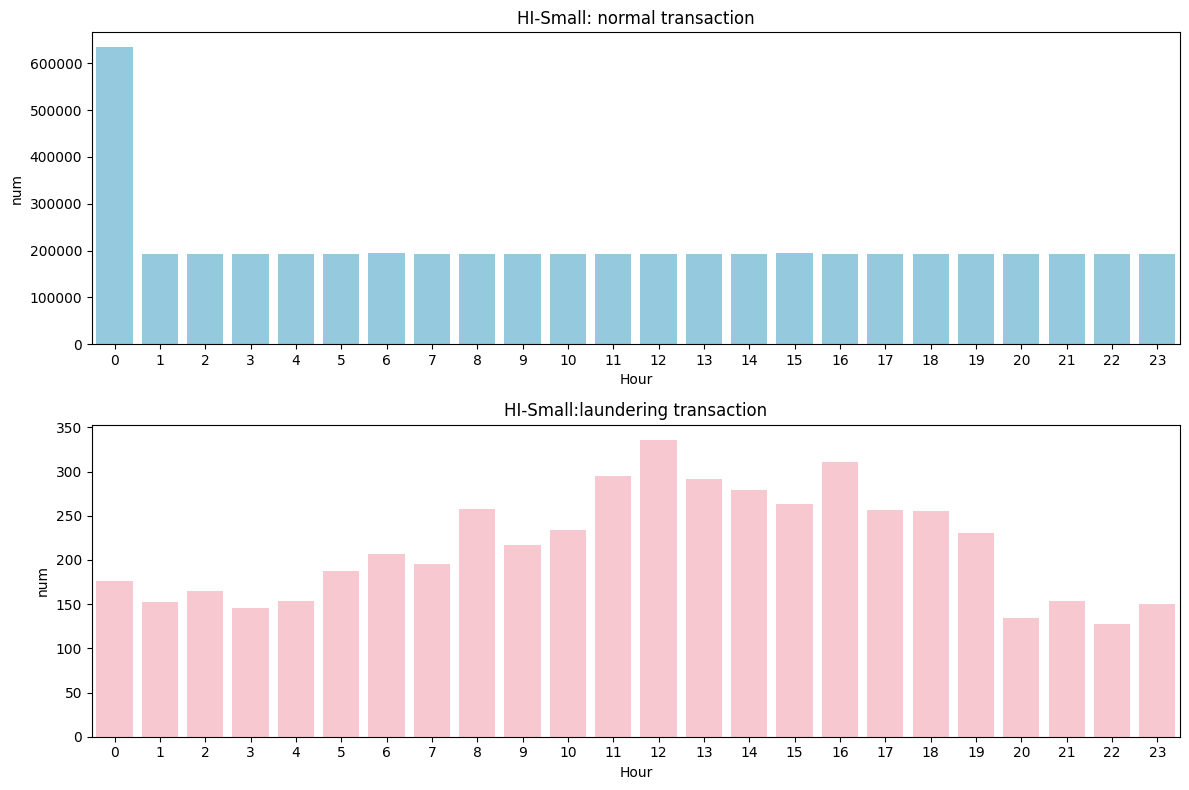

In [223]:
# 거래시간대별 거래량 비교
fig, axes = plt.subplots(2, 1, figsize=(12,8))

sns.barplot(df_0_hour, x='Hour', y='num', ax=axes[0], color = 'skyblue')
axes[0].set_title("HI-Small: normal transaction")
sns.barplot(df_1_hour, x='Hour', y='num', ax=axes[1], color = 'pink')
axes[1].set_title("HI-Small:laundering transaction")
plt.tight_layout()
plt.show()

거래시간에 따른 거래량 분포의 차이가 있어보임.

### 평균거래량 비교
- 전체 평균거래량, 일반계좌 평균거래량, 사기계좌 평균거래량

In [238]:
# 거래량 비교 - 송금계좌
account_tx_count = df.groupby(['Is Laundering','Sender Account']).size().reset_index(name='transaction_count')
account_tx_count

,Is Laundering,Sender Account,transaction_count
0,0,100428660,168429
1,0,1004286A8,102860
2,0,1004286F0,18642
3,0,100428738,13733
4,0,100428780,17243
...,...,...,...
993985,1,814965980,0
993986,1,8149659D0,0
993987,1,814965AB0,0
993988,1,814965B00,2


In [240]:
# 계좌 100428660의 평균거래횟수
df[df['Sender Account'] == '100428660']

,Timestamp,From Bank,Sender Account,To Bank,Recipient Account,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering,Date,Hour,Day of Week,Charge,hour_sin,hour_cos
127,2022-09-01 00:25:00,70,100428660,10,800059F50,5105.92,US Dollar,5105.92,US Dollar,Cheque,0,2022-09-01,0,3,0.0,0.000000,1.000000
301,2022-09-01 00:16:00,70,100428660,220,800132390,15509630.09,US Dollar,15509630.09,US Dollar,Cheque,0,2022-09-01,0,3,0.0,0.000000,1.000000
302,2022-09-01 00:01:00,70,100428660,220,800132390,18722.79,US Dollar,18722.79,US Dollar,Credit Card,0,2022-09-01,0,3,0.0,0.000000,1.000000
303,2022-09-01 00:03:00,70,100428660,220,800132390,19780972.52,US Dollar,19780972.52,US Dollar,Cash,0,2022-09-01,0,3,0.0,0.000000,1.000000
473,2022-09-01 00:14:00,70,100428660,220,800190EB0,22605.52,US Dollar,22605.52,US Dollar,Cheque,0,2022-09-01,0,3,0.0,0.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5075828,2022-09-10 23:31:00,70,100428660,51182,8139CDF40,305.17,US Dollar,305.17,US Dollar,Credit Card,0,2022-09-10,23,5,0.0,-0.258819,0.965926
5075829,2022-09-10 23:44:00,70,100428660,51182,8139CDF40,28.42,US Dollar,28.42,US Dollar,Cash,0,2022-09-10,23,5,0.0,-0.258819,0.965926
5075836,2022-09-10 23:53:00,70,100428660,122080,8139E7180,289.78,US Dollar,289.78,US Dollar,Cheque,0,2022-09-10,23,5,0.0,-0.258819,0.965926
5075837,2022-09-10 23:50:00,70,100428660,122080,8139E7180,82.90,US Dollar,82.90,US Dollar,Credit Card,0,2022-09-10,23,5,0.0,-0.258819,0.965926


In [246]:
# 사기 여부별 평균 거래 횟수 계산
avg_tx_count_by_laundery = account_tx_count.groupby('Is Laundering')['transaction_count'].mean().reset_index()
avg_tx_count_by_laundery

,Is Laundering,transaction_count
0,0,10.207684
1,1,0.010417


In [272]:
# 거래시간대별 거래량 비교 - 결과가 안나옴(아마도 데이터가 커서 그런듯)
# sns.displot(x=account_tx_count['transaction_count'], hue=account_tx_count['Is Laundering'])
# plt.show()

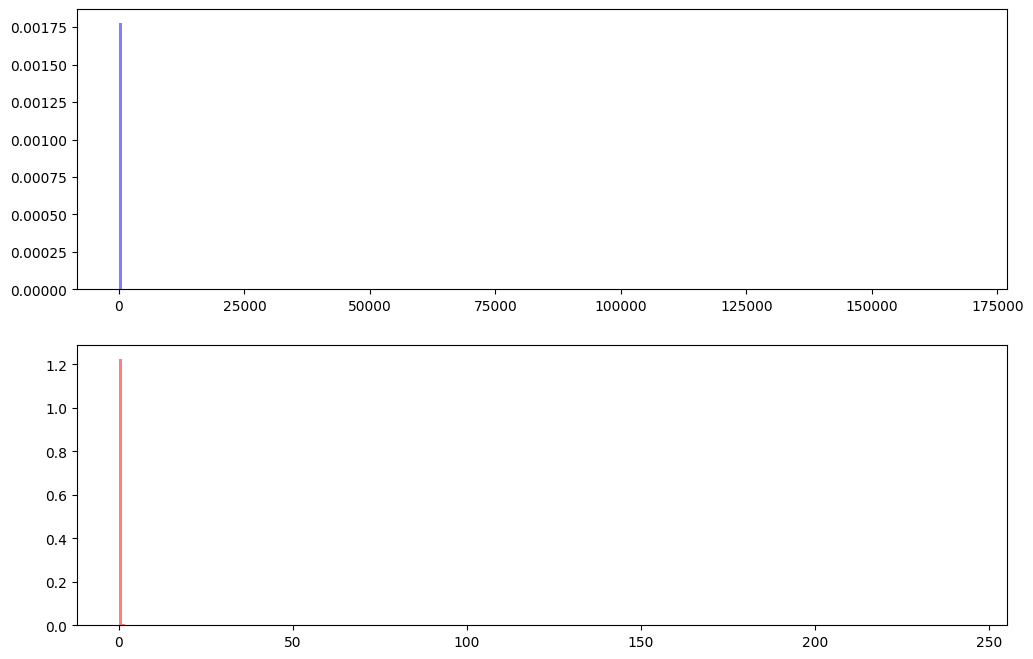

In [276]:
# 거래시간대별 거래량 비교
# 히스토그램 그리기 - 잘못그림
	
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

axes[0].hist(account_tx_count.loc[account_tx_count['Is Laundering'] == 0, 'transaction_count'], bins=300, alpha=0.5, color="blue", label="normal", density=True)
axes[1].hist(account_tx_count.loc[account_tx_count['Is Laundering'] == 1, 'transaction_count'], bins=300, alpha=0.5, color="red", label="laundering", density=True)
plt.show()

In [244]:
# 거래량 비교 -수취 계좌
rcv_account_tx_count = df.groupby(['Is Laundering','Recipient Account']).size().reset_index(name='transaction_count')
rcv_account_tx_count

,Is Laundering,Recipient Account,transaction_count
0,0,100428660,1084
1,0,1004286A8,653
2,0,1004286F0,108
3,0,100428738,98
4,0,100428780,117
...,...,...,...
841267,1,814965980,0
841268,1,8149659D0,0
841269,1,814965AB0,0
841270,1,814965B00,4


In [248]:
# 사기 여부별 평균 거래 횟수 계산
rcv_avg_tx_count_by_laundery = rcv_account_tx_count.groupby('Is Laundering')['transaction_count'].mean().reset_index()
rcv_avg_tx_count_by_laundery

,Is Laundering,transaction_count
0,0,12.060708
1,1,0.012308
